# Mimicing Portfolios for Cross-Sectional Dispersion
* ### See the correlation between CSD and returns
* ### Use it to price the cross-sectional dispersion

## Import

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
from multiprocessing import Pool
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
pd.options.display.max_rows=100
from tabulate import tabulate

# !pip install yfinance
# import yfinance as yf

# ! pip install bt
# import bt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Storing the data
'''
# nasdaq_list = pd.read_csv(f"/content/drive/My Drive/FIN554/nasdaq_list.csv").Symbol
# nyse_list = pd.read_csv(f"/content/drive/My Drive/FIN554/nyse_list.csv").Symbol
# amex_list = pd.read_csv(f"/content/drive/My Drive/FIN554/amex_list.csv").Symbol
# whole_list = set(nasdaq_list).union(set(nyse_list)).union(set(amex_list))
whole_list = set(pd.read_csv(f"/content/drive/My Drive/FIN554/Tickers2012.csv", index_col=0).tickers.to_list())

# del nasdaq_list
# del nyse_list
# del amex_list

import time

for date in ['2010-2019', '2000-2009', '1990-1999']:
  data = pd.read_csv(f"/content/drive/My Drive/FIN554/Data{date}.csv")
  data_new = data.loc[data.tic.isin(whole_list)]
  del data
  
  time.sleep(10)
  
  close_data = data_new.pivot_table(index = "datadate", columns = ["tic"], values = ["prccd"], aggfunc = "mean")
  close_data.to_hdf(f"/content/drive/My Drive/FIN554/ClosePrice_2012.h5", key = date, complevel = 9, complib = 'blosc')
  del close_data

  share_data = data_new.pivot_table(index = "datadate", columns = ["tic"], values = ["cshoc"], aggfunc = "mean")
  share_data.to_hdf(f"/content/drive/My Drive/FIN554/ShareOutstanding_2012.h5", key = date, complevel = 9, complib = 'blosc')
  del share_data

  adj_data = data_new.pivot_table(index = "datadate", columns = ["tic"], values = ["ajexdi"], aggfunc = "mean")
  adj_data.to_hdf(f"/content/drive/My Drive/FIN554/AdjustFactor_2012.h5", key = date, complevel = 9, complib = 'blosc')
  del adj_data
  
  trfd_data = data_new.pivot_table(index = "datadate", columns = ["tic"], values = ["trfd"], aggfunc = "mean")
  trfd_data.to_hdf(f"/content/drive/My Drive/FIN554/TrfdFactor_2012.h5", key = date, complevel = 9, complib = 'blosc')
  del trfd_data

  del data_new

  time.sleep(10)
'''

## Framework for regressions

In [133]:
# Reference: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
def regression_stocks(stock_prices, factors, beta):
  '''
  stock_prices: dataframe of stocks and factors returns
  factors: a list of factors to do the regression
  '''
  betas = []
  for stock in tqdm(stock_prices.stocks.columns, f"regression on {stock_prices.index[-1]}"):
    X_Y = pd.concat([stock_prices.factors.loc[:, factors], stock_prices.stocks.loc[:, stock]], axis = 1)
    X_Y = X_Y.dropna()
    if X_Y.shape[0]<15:
      if beta == 'residual':
        betas.append(pd.Series(np.nan, index = stock_prices.index))
      else:
        betas.append(None)
      continue
    X = X_Y.loc[:, factors]
    Y = X_Y.loc[:, stock]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    if beta == 'residual':
      betas.append(Y.sub(results.predict(X)))
    else:
      betas.append(results.params[beta])
  if beta == 'residual':
    return_df = pd.concat(betas, axis =1)
    return_df.columns = stock_prices.stocks.columns
    return return_df
  else:
    return pd.Series(betas, index = stock_prices.stocks.columns, name = stock_prices.index[-1])


def get_weights(beta_df, ref_index, mv_df):
  ### Align the Index
  new_index = sorted(list(set(beta_df.index).intersection(set(pd.DatetimeIndex(ref_index.astype(str))))))
  ### Quantile1-Quantile5
  No5=(beta_df.sub(beta_df.quantile(q=0.8, axis=1), axis = 0)>=0).loc[new_index].mul(mv_df.loc[new_index])
  No5 = No5.fillna(0)
  No5 = No5.div(No5.sum(axis = 1), axis = 0)

  No4=((beta_df.sub(beta_df.quantile(q=0.8, axis=1), axis = 0)<=0) & \
  (beta_df.sub(beta_df.quantile(q=0.6, axis=1), axis = 0)>0)).loc[new_index].mul(mv_df.loc[new_index])
  No4 = No4.fillna(0)
  No4 = No4.div(No4.sum(axis = 1), axis = 0)

  No3=((beta_df.sub(beta_df.quantile(q=0.6, axis=1), axis = 0)<=0) & \
  (beta_df.sub(beta_df.quantile(q=0.4, axis=1), axis = 0)>0)).loc[new_index].mul(mv_df.loc[new_index])
  No3 = No3.fillna(0)
  No3 = No3.div(No3.sum(axis = 1), axis = 0)

  No2=((beta_df.sub(beta_df.quantile(q=0.4, axis=1), axis = 0)<=0) & \
  (beta_df.sub(beta_df.quantile(q=0.2, axis=1), axis = 0)>0)).loc[new_index].mul(mv_df.loc[new_index])
  No2 = No2.fillna(0)
  No2 = No2.div(No2.sum(axis = 1), axis = 0)

  No1=(beta_df.sub(beta_df.quantile(q=0.2, axis=1), axis = 0)<=0).loc[new_index].mul(mv_df.loc[new_index])
  No1 = No1.fillna(0)
  No1 = No1.div(No1.sum(axis = 1), axis = 0)
  ### Negative-Positive
  Neg=(beta_df < 0).loc[new_index].mul(mv_df.loc[new_index])
  Neg = Neg.fillna(0)
  Neg = Neg.div(Neg.sum(axis = 1), axis = 0)
  Pos=(beta_df > 0).loc[new_index].mul(mv_df.loc[new_index])
  Pos = Pos.fillna(0)
  Pos = Pos.div(Pos.sum(axis = 1), axis = 0)

  return No1, No2, No3, No4, No5, Neg, Pos, new_index


def run_backtest(test_data, long_weights, short_weights, name_s):
  long_s = bt.Strategy('long', [bt.algos.RunMonthly(),
                        #  bt.algos.SelectWhere(No5),
                        bt.algos.WeighTarget(long_weights),
                        #  bt.algos.WeighEqually(),
                        bt.algos.Rebalance()])

  short_s = bt.Strategy('short', [bt.algos.RunMonthly(),
                        #  bt.algos.SelectWhere(No1),
                        bt.algos.WeighTarget(short_weights.mul(-1)),
                        #  bt.algos.WeighEqually(),
                        bt.algos.Rebalance()])

  long_short = bt.Strategy(name_s, [bt.algos.RunMonthly(),
                                  bt.algos.SelectAll(),
                                  bt.algos.WeighEqually(),
                                  bt.algos.Rebalance()],
                      [long_s, short_s])

  test = bt.Backtest(long_short, test_data, integer_positions=True, initial_capital=100000000.0)
  res = bt.run(test)

  return res

In [134]:
### close price data
close_df = pd.concat([pd.read_hdf("/content/drive/My Drive/FIN554/ClosePrice.h5", key = '1990-1999').prccd,\
                      pd.read_hdf("/content/drive/My Drive/FIN554/ClosePrice.h5", key = '2000-2009').prccd,\
                      pd.read_hdf("/content/drive/My Drive/FIN554/ClosePrice.h5", key = '2010-2019').prccd],\
                      axis = 0, join = 'inner')
### select data after 1995-12-31
close_df = close_df.loc[close_df.index > 19951231 ]
### delete the date and stocks that are all empty
close_df.dropna(how = 'all', inplace = True)
close_df.dropna(how = 'all', axis = 1, inplace = True)

### adjust factors data
adjf_df = pd.concat([pd.read_hdf("/content/drive/My Drive/FIN554/AdjustFactor.h5", key = '1990-1999').ajexdi,\
                     pd.read_hdf("/content/drive/My Drive/FIN554/AdjustFactor.h5", key = '2000-2009').ajexdi,\
                     pd.read_hdf("/content/drive/My Drive/FIN554/AdjustFactor.h5", key = '2010-2019').ajexdi],\
                     axis = 0, join = 'inner')
### select data after 1995-12-31
adjf_df = adjf_df.align(close_df, join = 'right')[0]

### trfd factors data
trfd_df = pd.concat([pd.read_hdf("/content/drive/My Drive/FIN554/TrfdFactor.h5", key = '1990-1999').trfd,\
                     pd.read_hdf("/content/drive/My Drive/FIN554/TrfdFactor.h5", key = '2000-2009').trfd,\
                     pd.read_hdf("/content/drive/My Drive/FIN554/TrfdFactor.h5", key = '2010-2019').trfd],\
                     axis = 0, join = 'inner')
### select data after 1995-12-31
trfd_df = trfd_df.align(adjf_df, join = 'right')[0]

### calculate the adjusted close returns
adj_price = close_df.div(adjf_df)
adj_return = adj_price.mul(trfd_df).pct_change()
### replace infinity with previous return
adj_return.replace(np.inf, np.nan, inplace = True)
adj_return.pad(inplace = True)

### Daily MKT and RF factor data
mkt_rf_daily = pd.read_csv("/content/drive/My Drive/FIN554/Factors_daily.csv", header = 0, index_col = 0).loc[:, ["Mkt-RF", "RF"]].div(100)

### Calculate the CSD Factors
num_stocks = adj_return.shape[1]
### calculate the first order difference of CSD as our main variable
csd = adj_return.sub(mkt_rf_daily.loc[adj_return.index, "Mkt-RF"], axis= 0).abs().sum(axis = 1).div(num_stocks-1).diff()
mkt_rf_daily['CSD'] = csd

### calculate the access returns
return_daily = pd.concat([adj_return, mkt_rf_daily], axis = 1, join = 'inner', keys = ['stocks', 'factors'])
return_daily.stocks = return_daily.stocks.sub(return_daily.factors.RF, axis = 0)

In [135]:
### Market Share as Portfolio Weight
# *** Before 1998-04-01 only 3 or 4 not N/A per month ***
### Market Share data
mv_df = pd.concat([pd.read_hdf("/content/drive/My Drive/FIN554/ShareOutstanding.h5", key = '1990-1999').cshoc,\
                      pd.read_hdf("/content/drive/My Drive/FIN554/ShareOutstanding.h5", key = '2000-2009').cshoc,\
                      pd.read_hdf("/content/drive/My Drive/FIN554/ShareOutstanding.h5", key = '2010-2019').cshoc],\
                      axis = 0, join = 'inner')
### select data after 1995-12-31
mv_df = mv_df.loc[mv_df.index > 19951231 ]

mv_df = mv_df.align(return_daily.stocks, join = 'right')[0].mul(close_df)
mv_df.index = pd.DatetimeIndex(mv_df.index.astype(str))

# Part1. Mimicing Portfolio based on CSD factor

## Regression to get Beta

In [42]:
### group by month to generate regression data
regression_data = return_daily.copy(deep = True)
regression_data.index = pd.DatetimeIndex(return_daily.index.astype(str)).strftime("%Y-%m")

In [43]:
# Multithreading to speed up
# Reference: https://stackoverflow.com/questions/64831642/how-do-i-use-multiprocessing-on-python-to-speed-up-a-for-loop
# https://stackoverflow.com/questions/8533318/multiprocessing-pool-when-to-use-apply-apply-async-or-map

### store the result in dictionary
def log_result(result):
    beta_df.append(result)

pool = Pool(os.cpu_count())

# regression_data.fillna(method = 'ffill', inplace = True)
beta_df = []

### monthly regression
for idx, grouped_df in regression_data.groupby(level = 0):
  pool.apply_async(regression_stocks, args=(grouped_df,['Mkt-RF', 'CSD'], 'CSD'), callback = log_result)

pool.close()
pool.join()

beta_df = pd.concat(beta_df, axis=1).T

regression on 2020-12: 100%|██████████| 1984/1984 [00:19<00:00, 103.70it/s]


In [44]:
### save Beta of CSD factors
beta_df.to_csv("/content/drive/My Drive/FIN554/CSD_Betas.csv")

In [ ]:
beta_df = pd.read_csv("/content/drive/My Drive/FIN554/CSD_Betas.csv", index_col = 0)

## Construct the strategy: select quantiles first

In [46]:
### Reset the index of beta Dataframe into daily
beta_df = beta_df.shift()
beta_df.index = pd.to_datetime(beta_df.index)
beta_df = beta_df.resample('1d').mean()
beta_df.pad(inplace = True)

In [47]:
### use data only after 1998-04-01
beta_df = beta_df.loc['19980401':]

In [136]:
### generate portfolio weights
No1, No2, No3, No4, No5, Neg, Pos, new_index = get_weights(beta_df, return_daily.index, mv_df)

In [ ]:
### Prepare Backtesting Data
test_data = close_df.copy(deep = True)
test_data.index = pd.DatetimeIndex(test_data.index.astype(str))
test_data = test_data.loc[new_index]
test_data.replace(0, np.nan, inplace = True)
test_data = test_data.fillna(method = 'ffill').fillna(method = 'bfill')

In [ ]:
### 1-5 Portfolio
res_1 = run_backtest(No1, No5, '1-5')

### N-P Portfolio
res_2 = run_backtest(Neg, Pos, 'N-P')

### Performance

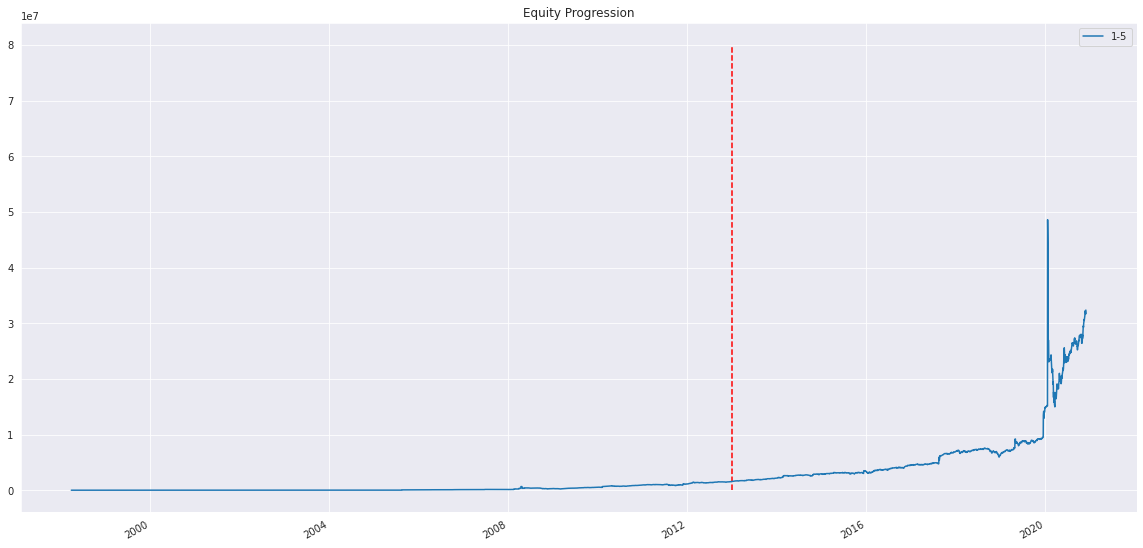

Stat                 1-5
-------------------  ------------
Start                1998-03-31
End                  2020-12-01
Risk-free rate       0.00%

Total Return         32377194.49%
Daily Sharpe         0.64
Daily Sortino        4.01
CAGR                 75.00%
Max Drawdown         -92.92%
Calmar Ratio         0.81

MTD                  2.23%
3m                   19.38%
6m                   48.67%
YTD                  130.14%
1Y                   249.59%
3Y (ann.)            68.35%
5Y (ann.)            58.92%
10Y (ann.)           43.63%
Since Incep. (ann.)  75.00%

Daily Sharpe         0.64
Daily Sortino        4.01
Daily Mean (ann.)    115.15%
Daily Vol (ann.)     178.55%
Daily Skew           36.38
Daily Kurt           1500.19
Best Day             514.33%
Worst Day            -92.63%

Monthly Sharpe       0.29
Monthly Sortino      16.01
Monthly Mean (ann.)  169.96%
Monthly Vol (ann.)   582.35%
Monthly Skew         16.40
Monthly Kurt         270.35
Best Month           2774.97%
Wors

In [ ]:
fig1=plt.figure()
res_1.plot(ax=fig1.gca(), figsize=(20, 10))
plt.legend()
plt.vlines(x = '2012-12-31', ymin = 0, ymax = 8*(10**7), color = 'r', linestyle = 'dashed')
plt.show()
res_1.display()

In [ ]:
res_1.display_monthly_returns()

  Year    Jan     Feb     Mar    Apr    May    Jun    Jul      Aug     Sep     Oct     Nov    Dec      YTD
------  -----  ------  ------  -----  -----  -----  -----  -------  ------  ------  ------  -----  -------
  1998   0       0       0      1.39  -2.91  -1.91  -4.04   -15.4     4.13    5.19    4.83  51.89    36.71
  1999   8.44   -1.84   -0.38   7      1.34   4.16  -0.42    -2.55   -1.8    -0.26    5.67   5.08    26.39
  2000   3.55    8.69    5.54  -4.03  -2.79   3.68   0.22     5.86   -2.16   -3.12   -7.04   2.54    10.12
  2001  12.6    -4.12   -3.87   7.69   7.2    3.41  -0.47    -1.77  -10.25    6.3    15.12   6.14    41.21
  2002   2.3     7.31    7.01   0.05  -0.59   1.58  -7.78     1.36   -6.72    4.24   10.26  -2.04    16.52
  2003   0.36   -1.66    6.11  13.97  11.63   4.03   5.74     4.99    2.33    9.37    4.94   5.43    90.51
  2004  29.22    6.03    1.34  -2.88   0.37   4.43  -3.75    -0.4     5.13    6.03   13.36   0.42    71.94
  2005  -2.09    9.87   -2.41  42.24 

In [ ]:
res_1.stats

,1-5
start,1998-03-31 00:00:00
end,2020-12-01 00:00:00
rf,0.0
total_return,323771.944946
cagr,0.750008
max_drawdown,-0.92918
calmar,0.807172
mtd,0.02233
three_month,0.193823
six_month,0.48674


Stat                 N-P
-------------------  ------------
Start                1998-03-31
End                  2020-12-01
Risk-free rate       0.00%

Total Return         32369162.04%
Daily Sharpe         0.64
Daily Sortino        4.01
CAGR                 75.00%
Max Drawdown         -92.92%
Calmar Ratio         0.81

MTD                  2.23%
3m                   19.38%
6m                   48.65%
YTD                  130.09%
1Y                   249.50%
3Y (ann.)            68.34%
5Y (ann.)            58.91%
10Y (ann.)           43.63%
Since Incep. (ann.)  75.00%

Daily Sharpe         0.64
Daily Sortino        4.01
Daily Mean (ann.)    115.15%
Daily Vol (ann.)     178.55%
Daily Skew           36.38
Daily Kurt           1500.19
Best Day             514.33%
Worst Day            -92.63%

Monthly Sharpe       0.29
Monthly Sortino      16.01
Monthly Mean (ann.)  169.96%
Monthly Vol (ann.)   582.35%
Monthly Skew         16.40
Monthly Kurt         270.35
Best Month           2774.96%
Wors

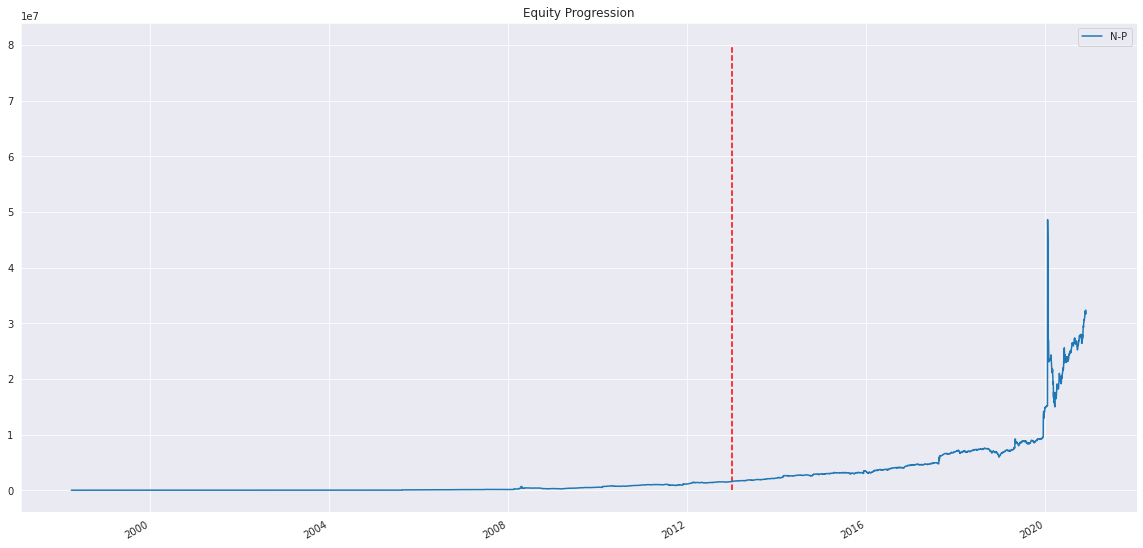

In [ ]:
fig2=plt.figure()
res_2.plot(ax=fig2.gca(), figsize=(20, 10))
plt.legend()
plt.vlines(x = '2012-12-31', ymin = 0, ymax = 8*(10**7), color = 'r', linestyle = 'dashed')
res_2.display()

In [ ]:
res_2.display_monthly_returns()

  Year    Jan     Feb     Mar    Apr    May    Jun    Jul      Aug     Sep     Oct     Nov    Dec      YTD
------  -----  ------  ------  -----  -----  -----  -----  -------  ------  ------  ------  -----  -------
  1998   0       0       0      1.4   -2.91  -1.91  -4.04   -15.4     4.13    5.19    4.82  51.91    36.74
  1999   8.44   -1.85   -0.39   7      1.34   4.15  -0.43    -2.55   -1.8    -0.26    5.67   5.08    26.34
  2000   3.56    8.68    5.54  -4.02  -2.79   3.68   0.22     5.86   -2.17   -3.13   -7.04   2.54    10.12
  2001  12.6    -4.12   -3.87   7.68   7.2    3.42  -0.47    -1.77  -10.25    6.31   15.12   6.14    41.18
  2002   2.3     7.31    7.01   0.06  -0.59   1.58  -7.79     1.37   -6.73    4.24   10.26  -2.03    16.52
  2003   0.36   -1.66    6.11  13.97  11.64   4.03   5.74     4.98    2.33    9.37    4.94   5.44    90.52
  2004  29.21    6.03    1.34  -2.86   0.38   4.45  -3.75    -0.4     5.14    6.03   13.36   0.41    71.98
  2005  -2.08    9.87   -2.41  42.24 

### CSD time-series
* actually this is daily return series

In [142]:
y = return_daily.stocks.AAPL.dropna()
x = return_daily.factors.loc[:, ['Mkt-RF', 'CSD']].loc[y.index]
x= sm.add_constant(x)
sm.OLS(y, x).fit().params

const     0.000894
Mkt-RF    1.144153
CSD      -0.002395
dtype: float64

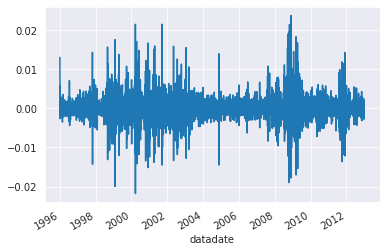

In [80]:
csd.index = pd.DatetimeIndex(csd.index.astype(str))
csd.loc['1996-01-03':'2012-12-31'].plot()

In [97]:
adj_return.sub(mkt_rf_daily.loc[adj_return.index, "Mkt-RF"], axis= 0).abs().sum(axis = 1).head()

datadate
19960102     0.000000
19960103    25.766096
19960104    26.385840
19960105    23.317274
19960108    18.069824
dtype: float64

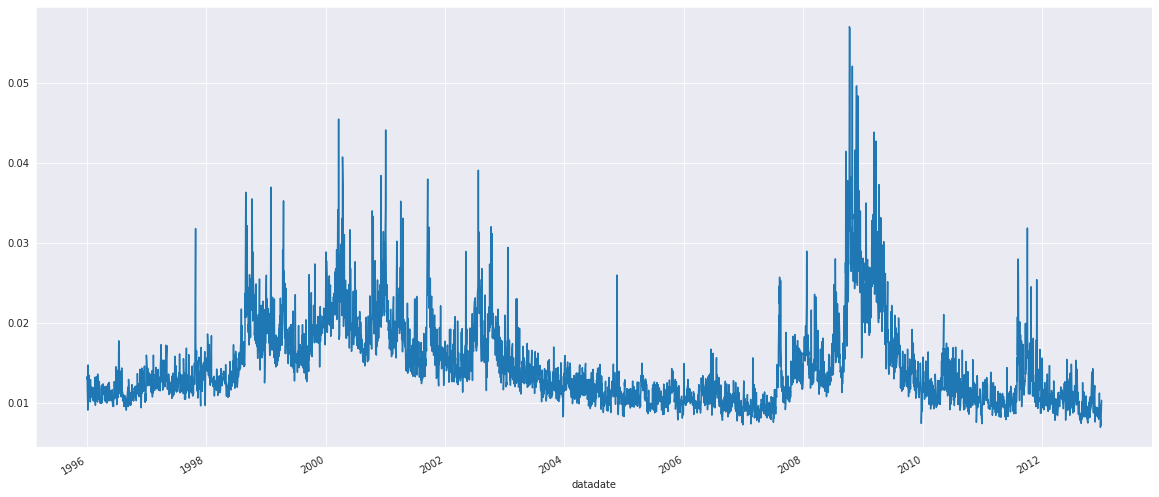

In [137]:
CSD = adj_return.sub(mkt_rf_daily.loc[adj_return.index, "Mkt-RF"], axis= 0).abs().sum(axis = 1).div(num_stocks-1)
CSD.index = pd.DatetimeIndex(CSD.index.astype(str))
CSD.loc['1996-01-03':'2012-12-31'].plot(figsize = (20, 9))

In [138]:
def long_short_return(long_pos, short_pos):
  if isinstance(short_pos,pd.DataFrame):
    short_ret = return_data.align(short_pos, join = 'right', axis = 0)[0].mul(short_pos).sum(axis=1)
  else:
    short_ret = 0
  long_ret = return_data.align(long_pos, join = 'right', axis = 0)[0].mul(long_pos).sum(axis=1)
  return long_ret.sub(short_ret)

In [144]:
one.loc[:'2012-12-31'].mean(), two.loc[:'2012-12-31'].mean(), three.loc[:'2012-12-31'].mean(), four.loc[:'2012-12-31'].mean(), five.loc[:'2012-12-31'].mean()

(0.0007977804156669232,
 0.0007356258834029926,
 0.000597858251628662,
 0.0007316551664666146,
 0.0008258843332023835)

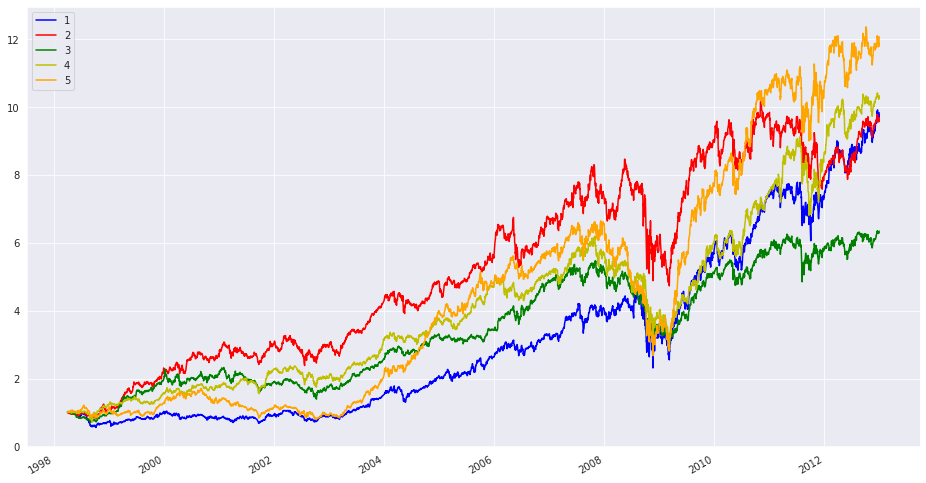

In [143]:
ax = plt.subplot(111)

# N_P = long_short_return(Neg, Pos)
# one_five = long_short_return(No1, No5)
one = long_short_return(No1, None).loc[:'2012-12-31']
two = long_short_return(No2, None).loc[:'2012-12-31']
three = long_short_return(No3, None).loc[:'2012-12-31']
four = long_short_return(No4, None).loc[:'2012-12-31']
five = long_short_return(No5, None).loc[:'2012-12-31']
# N_P.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='r', label = 'N-P')
# one_five.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='b', label = '1-5')
one.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='b', label = '1')
two.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='r', label = '2')
three.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='g', label = '3')
four.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='y', label = '4')
five.add(1).cumprod().plot(figsize = (16,9), ax= ax, color ='orange', label = '5')

plt.legend()

### Table 1 Results

In [ ]:
sorted_portfolios = [No1, No2, No3, No4, No5]
table = []

### Sorted Portfolios
for i in range(len(sorted)):
  row = [i+1]
  No = sorted_portfolios[i]
  ### mean and std of return
  ret = return_data.align(No, join = 'right', axis = 0)[0].mul(No).sum(axis=1)
  ret.replace(np.inf, np.nan, inplace = True)
  ret.dropna(inplace = True)
  
  row.extend([round(ret.mean(),4), round(ret.std(),4)])
  ### pre and post formation beta
  row.append(round(No.mul(beta_df).sum(axis = 1).mean(),4))
  X = csd.align(No, join = 'right', axis = 0)[0]
  Y = ret
  X.pad(inplace = True)

  row.append(round(sm.OLS(Y, X).fit().params[0],4))
  ### Mkt Share
  mv_shares = No.where(No>0)
  mv_shares[mv_shares>0] = 1 
  row.append(round(mv_shares.mul(mv_df.align(No, join = 'right', axis = 0)[0]).sum(axis = 1).mean(),4))
  table.append(row)

mean_shares = sum([row[-1] for row in table])
for row in table:
  row[-1] = row[-1]/mean_shares/100

### Spred portfolios
from scipy.stats import ttest_1samp as ttest

table.append(['1-5', f'{one_five.mean()}({round(ttest(one_five, 0).statistic,2)})', None, None, None, None])
table.append(['N-P', f'{N_P.mean()}({round(ttest(N_P, 0).statistic,2)})', None, None, None, None])

In [ ]:
print(tabulate(table, headers = ['Portfolios', 'Mean', 'Std', 'Pre-formation beta', 'Post-formation beta', 'Mkt-Share(%)'], tablefmt="rst"))

============  ===========================  ======  ====================  =====================  ==============
Portfolios    Mean                            Std    Pre-formation beta    Post-formation beta    Mkt-Share(%)
============  ===========================  ======  ====================  =====================  ==============
1             -0.0064                      0.0192               -0.0057                -0.0009      0.00137142
2             -0.0067                      0.0159               -0.0018                -0.0006      0.00246187
3             -0.0067                      0.016                 0                     -0.0004      0.00220972
4             -0.0068                      0.0168                0.0019                -0.0001      0.00245797
5             -0.0065                      0.0179                0.0059                -0.0007      0.00149902
1-5           3.958051745327492e-05(0.21)
N-P           9.299432568386587e-06(0.08)
============  ==============

## Test Risk Adjusted Returns

In [ ]:
### Fetch the monthly returns for mimicing portfolios
def monthly_return(x):
  return x.add(1).cumprod().iloc[-1]-1

one_five = one_five.to_frame(name = '1-5')
N_P = N_P.to_frame(name = 'N-P')

one_five['month'] = one_five.index.strftime('%Y-%m')
N_P['month'] = N_P.index.strftime('%Y-%m')

return_1_5 = one_five.groupby(['month']).apply(lambda x: monthly_return(x))
return_N_P = N_P.groupby(['month']).apply(lambda x: monthly_return(x))

In [ ]:
return_1_5.index = return_1_5.index.str[:4] + return_1_5.index.str[-2:]
return_N_P.index = return_N_P.index.str[:4] + return_N_P.index.str[-2:]

In [ ]:
### montly factors data
factors_monthly = pd.read_csv('/content/drive/My Drive/FIN554/Factors.csv', index_col = 0)
factors_monthly.index = factors_monthly.index.astype(str)
factors_monthly = factors_monthly.loc[return_1_5.index]

### access returns
return_1_5 = return_1_5.sub(factors_monthly.RF, axis = 0)
return_N_P = return_N_P.sub(factors_monthly.RF, axis = 0)

In [ ]:
factors_monthly.rename(columns = {'Mom   ': 'Mom'}, inplace = True)

In [ ]:
### Linear Regression on factors to see risk-adjusted returns
import statsmodels.api as sm

X = factors_monthly.loc[:, ['Mkt-RF', 'SMB', 'HML', 'Mom']]
Y1 = return_1_5
Y2 = return_N_P

X = sm.add_constant(X)

reg1 = sm.OLS(Y1, X).fit()
reg2 = sm.OLS(Y2, X).fit()

In [ ]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    N-P   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.328
Date:                Wed, 09 Mar 2022   Prob (F-statistic):             0.0566
Time:                        03:17:52   Log-Likelihood:                 108.80
No. Observations:                 273   AIC:                            -207.6
Df Residuals:                     268   BIC:                            -189.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1504      0.010    -14.934      0.000      -0.170      -0.131
Mkt-RF         0.0018      0.002      0.752      0.452      -0.003       0.007
SMB            0.0025      0.003      0.793      0.428      -0.004       0.009
HML           -0.0055      0.003     -1.700      0.090      -0.012       0.001
Mom           -0.0039      0.002     -1.862      0.064      -0.008       0.000
==============================================================================
Omnibus:                       27.040   Durbin-Watson:                   0.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.254
Skew:                          -0.825   Prob(JB):                     9.91e-08
Kurtosis:                       2.660   Cond. No.                         5.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 2 Results

In [ ]:
### create table 2
tvalues1 = reg1.tvalues.to_list()
tvalues2 = reg2.tvalues.to_list()
params1 = reg1.params.to_list()
params2 = reg2.params.to_list()
col1 = [str(round(params1[i],4))+'('+str(round(tvalues1[i],2))+')' for i in range(5)] + [0.027]
col2 = [str(round(params2[i],4))+'('+str(round(tvalues2[i],2))+')' for i in range(5)] + [0.034]

table2 = list(zip(*[['constant', 'MKT', 'SMB', 'HML', 'MOM', 'Adj.R^2'], col1, col2]))

In [ ]:
print(tabulate(table2, headers = [ '1-5', 'N-P'], tablefmt="rst"))

========  ==============  ===============
..        1-5             N-P
========  ==============  ===============
constant  -0.152(-14.73)  -0.1504(-14.93)
MKT       0.0035(1.41)    0.0018(0.75)
SMB       0.0015(0.46)    0.0025(0.79)
HML       -0.0056(-1.69)  -0.0055(-1.7)
MOM       -0.0009(-0.41)  -0.0039(-1.86)
Adj.R^2   0.027           0.034
========  ==============  ===============


## Robustness

### 1. formation window

#### 3 months

In [ ]:
### store the result in dictionary
def log_result_3month(result):
    beta_3month.append(result)

from multiprocessing import Pool
import os

pool = Pool(os.cpu_count())

# regression_data.fillna(method = 'ffill', inplace = True)
beta_3month = []

### 3month regression
months = regression_data.index.unique()
for i in tqdm(range(len(months)-2)):
  grouped_df = regression_data.loc[months[i]: months[i+2]]
  pool.apply_async(regression_stocks, args=(grouped_df,['Mkt-RF', 'CSD'], 'CSD'), callback = log_result_3month)

pool.close()
pool.join()

beta_3month = pd.concat(beta_3month, axis=1).T

In [ ]:
### save Beta of CSD factors
beta_3month.to_csv("/content/drive/My Drive/FIN554/CSD_Betas_3month.csv")

In [ ]:
### read Beta of CSD factors
beta_3month = pd.read_csv("/content/drive/My Drive/FIN554/CSD_Betas_3month.csv", index_col = 0)
# beta_3month

In [ ]:
### Reset the index of beta Dataframe into daily
beta_3month = beta_3month.shift()
beta_3month.index = pd.to_datetime(beta_3month.index)
beta_3month = beta_3month.resample('1d').mean()
beta_3month.pad(inplace = True)

### use data only after 1998-04-01
beta_3month = beta_3month.loc['19980401':]

### generate portfolio weights
No1, No2, No3, No4, No5, Neg, Pos, new_index = get_weights(beta_3month, return_daily.index)

In [ ]:
N_P = long_short_return(Neg, Pos)
one_five = long_short_return(No1, No5)

In [ ]:
X = sm.add_constant(factors.loc[N_P.index, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

In [ ]:
row_3month = [one_five.mean(), sm.OLS(one_five, X).fit().params['const'], N_P.mean(), sm.OLS(N_P, X).fit().params['const']]
row_3month = [round(x, 5) for x in row_3month]
row_3month

[-0.00042, -0.00047, 0.00018, 0.0002]

#### 6 months

In [ ]:
### store the result in dictionary
def log_result_6month(result):
    beta_6month.append(result)

pool = Pool(os.cpu_count())

# regression_data.fillna(method = 'ffill', inplace = True)
beta_6month = []

### 6month regression
months = regression_data.index.unique()
for i in tqdm(range(len(months)-5)):
  grouped_df = regression_data.loc[months[i]: months[i+5]]
  pool.apply_async(regression_stocks, args=(grouped_df,['Mkt-RF', 'CSD'], 'CSD'), callback = log_result_6month)

pool.close()
pool.join()

beta_6month = pd.concat(beta_6month, axis=1).T

In [ ]:
### save Beta of CSD factors
beta_6month.to_csv("/content/drive/My Drive/FIN554/CSD_Betas_6month.csv")

In [ ]:
### read Beta of CSD factors
beta_6month = pd.read_csv("/content/drive/My Drive/FIN554/CSD_Betas_6month.csv", index_col = 0)
# beta_3month

In [ ]:
### Reset the index of beta Dataframe into daily
beta_6month = beta_6month.shift()
beta_6month.index = pd.to_datetime(beta_6month.index)
beta_6month = beta_6month.resample('1d').mean()
beta_6month.pad(inplace = True)

### use data only after 1998-04-01
beta_6month = beta_6month.loc['19980401':]

### generate portfolio weights
No1, No2, No3, No4, No5, Neg, Pos, new_index = get_weights(beta_6month, return_daily.index)

In [ ]:
N_P = long_short_return(Neg, Pos)
one_five = long_short_return(No1, No5)
X = sm.add_constant(factors.loc[N_P.index, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

In [ ]:
row_6month = [one_five.mean(), sm.OLS(one_five, X).fit().params['const'], N_P.mean(), sm.OLS(N_P, X).fit().params['const']]
row_6month = [round(x, 5) for x in row_6month]
row_6month

[-0.00016, -0.0002, 0.00024, 0.00025]

### 2. Sign of market

Negative MKT

In [ ]:
mkt_neg = set(mkt.loc[mkt<0].index).intersection(set(one_five.index))

X = sm.add_constant(factors.loc[mkt_neg, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

row_mkt_neg = [one_five.loc[mkt_neg].mean(), sm.OLS(one_five.loc[mkt_neg], X).fit().params['const'], N_P.loc[mkt_neg].mean(), sm.OLS(N_P.loc[mkt_neg], X).fit().params['const']]
row_mkt_neg = [round(x, 5) for x in row_mkt_neg]
row_mkt_neg

[-0.00054, 0.00031, 0.00019, -0.00013]

Positive MKT

In [ ]:
mkt_pos = set(mkt.loc[mkt>0].index).intersection(set(one_five.index))

X = sm.add_constant(factors.loc[mkt_pos, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

row_mkt_pos = [one_five.loc[mkt_pos].mean(), sm.OLS(one_five.loc[mkt_pos], X).fit().params['const'], N_P.loc[mkt_pos].mean(), sm.OLS(N_P.loc[mkt_pos], X).fit().params['const']]
row_mkt_pos = [round(x, 5) for x in row_mkt_pos]
row_mkt_pos

[0.00057, -0.00036, -0.00015, -0.00022]

Negative CSD

In [ ]:
csd_neg = set(csd.loc[csd<0].index).intersection(set(one_five.index))

X = sm.add_constant(factors.loc[csd_neg, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

row_csd_neg = [one_five.loc[csd_neg].mean(), sm.OLS(one_five.loc[csd_neg], X).fit().params['const'], N_P.loc[csd_neg].mean(), sm.OLS(N_P.loc[csd_neg], X).fit().params['const']]
row_csd_neg = [round(x, 5) for x in row_csd_neg]
row_csd_neg

[0.00015, 3e-05, -0.0002, -0.00015]

Positive CSD

In [ ]:
csd_pos = set(csd.loc[csd>0].index).intersection(set(one_five.index))

X = sm.add_constant(factors.loc[csd_pos, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

row_csd_pos = [one_five.loc[csd_pos].mean(), sm.OLS(one_five.loc[csd_pos], X).fit().params['const'], N_P.loc[csd_pos].mean(), sm.OLS(N_P.loc[csd_pos], X).fit().params['const']]
row_csd_pos = [round(x, 5) for x in row_csd_pos]
row_csd_pos

[-7e-05, -6e-05, 0.00022, 0.00021]

### 3. CSD as AR(1) innovations

In [ ]:
from statsmodels.tsa.ar_model import AR

ar = AR(csd.dropna()).fit(1)
fit_data = ar.predict(start = csd.index[2], end = csd.index[-1])
csd_ar = csd.sub(fit_data)
csd_ar.name = 'CSD_AR'

mkt_copy = return_daily.factors['Mkt-RF'].copy(deep = True)
mkt_copy.index = pd.DatetimeIndex(mkt_copy.index.astype(str))

regression_ar = pd.concat([return_data, pd.concat([mkt_copy, csd_ar], axis = 1)], axis = 1, keys = ['stocks', 'factors'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
regression_ar.index = pd.DatetimeIndex(regression_ar.index).strftime('%Y-%m')
### store the result in dictionary
def log_result_ar(result):
    beta_ar.append(result)

pool = Pool(os.cpu_count())

# regression_data.fillna(method = 'ffill', inplace = True)
beta_ar = []

### 6month regression
months = regression_ar.index.unique()
for i, grouped_df in regression_ar.groupby(level = 0):
  pool.apply_async(regression_stocks, args=(grouped_df,['Mkt-RF', 'CSD_AR'], 'CSD_AR'), callback = log_result_ar)

pool.close()
pool.join()

beta_ar = pd.concat(beta_ar, axis=1).T

In [ ]:
### save Beta of CSD factors
beta_ar.to_csv("/content/drive/My Drive/FIN554/CSD_Betas_AR1.csv") 

In [ ]:
beta_ar = pd.read_csv("/content/drive/My Drive/FIN554/CSD_Betas_AR1.csv", index_col = 0)
### Reset the index of beta Dataframe into daily
beta_ar = beta_ar.shift()
beta_ar.index = pd.to_datetime(beta_ar.index)
beta_ar = beta_ar.resample('1d').mean()
beta_ar.pad(inplace = True)

### use data only after 1998-04-01
beta_ar = beta_ar.loc['19980401':]

### generate portfolio weights
No1, No2, No3, No4, No5, Neg, Pos, new_index = get_weights(beta_ar, return_daily.index)

In [ ]:
N_P = long_short_return(Neg, Pos)
one_five = long_short_return(No1, No5)

X = sm.add_constant(factors.loc[N_P.index, ['Mkt-RF', 'SMB', 'HML', 'MOM']])

row_ar = [one_five.mean(), sm.OLS(one_five, X).fit().params['const'], N_P.mean(), sm.OLS(N_P, X).fit().params['const']]
row_ar = [round(x, 5) for x in row_ar]
row_ar

[0.00012, 9e-05, 2e-05, 3e-05]

### Table 5 Results

In [ ]:
row_ind = [None, 'mean', 'alpha', 'mean', 'alpha']
row_name1 = ['formation window', None, None, None, None]
row_name2 = ['MKT sign', None, None, None, None]
row_name3 = ['CSD sign', None, None, None, None]
row_name4 = ['CSD measure', None, None, None, None]

table5 = [row_ind, row_name1, ['3 months']+row_3month, ['6 months']+row_6month, row_name2, ['negative']+row_mkt_neg, ['positive']+row_mkt_pos,\
          row_name3, ['negative']+row_csd_neg, ['positive']+row_csd_pos, row_name4, ['AR(1)']+row_ar]

print(tabulate(table5, headers = ['1-5']*2 + ['N-P']*2, tablefmt="rst"))

================  ========  ========  ========  ========
..                1-5       1-5       N-P       N-P
================  ========  ========  ========  ========
                  mean      alpha     mean      alpha
formation window
3 months          -0.00042  -0.00047  0.00018   0.0002
6 months          -0.00016  -0.0002   0.00024   0.00025
MKT sign
negative          -0.00054  0.00031   0.00019   -0.00013
positive          0.00057   -0.00036  -0.00015  -0.00022
CSD sign
negative          0.00015   3e-05     -0.0002   -0.00015
positive          -7e-05    -6e-05    0.00022   0.00021
CSD measure
AR(1)             0.00012   9e-05     2e-05     3e-05
================  ========  ========  ========  ========


# Part2. Price the CSD

### Calculate Mimicing Portfolios as Factor

In [51]:
### mimicing portfolio function
def mimicing_portfolio(beta_df, return_data, mv_df, factor):  
  new_index = sorted(list(set(beta_df.index).intersection(set(pd.DatetimeIndex(return_data.index.astype(str))))))
  ### Quantile1 to Quantile5
  No5=(beta_df.sub(beta_df.quantile(q=0.8, axis=1), axis = 0)>=0).loc[new_index].mul(mv_df.loc[new_index])
  No5 = No5.fillna(0)
  No5 = No5.div(No5.sum(axis = 1), axis = 0)

  No4=((beta_df.sub(beta_df.quantile(q=0.8, axis=1), axis = 0)<0) & (beta_df.sub(beta_df.quantile(q=0.6, axis=1), axis = 0)>=0)).loc[new_index].mul(mv_df.loc[new_index])
  No4 = No4.fillna(0)
  No4 = No4.div(No4.sum(axis = 1), axis = 0)

  No3=((beta_df.sub(beta_df.quantile(q=0.6, axis=1), axis = 0)<0) & (beta_df.sub(beta_df.quantile(q=0.4, axis=1), axis = 0)>=0)).loc[new_index].mul(mv_df.loc[new_index])
  No3 = No3.fillna(0)
  No3 = No3.div(No3.sum(axis = 1), axis = 0)

  No2=((beta_df.sub(beta_df.quantile(q=0.4, axis=1), axis = 0)<0) & (beta_df.sub(beta_df.quantile(q=0.2, axis=1), axis = 0)>=0)).loc[new_index].mul(mv_df.loc[new_index])
  No2 = No2.fillna(0)
  No2 = No2.div(No2.sum(axis = 1), axis = 0)

  No1=(beta_df.sub(beta_df.quantile(q=0.2, axis=1), axis = 0)<=0).loc[new_index].mul(mv_df.loc[new_index])
  No1 = No1.fillna(0)
  No1 = No1.div(No1.sum(axis = 1), axis = 0)

  ### returns
  return_5 = return_data.align(No5, join = 'right')[0].mul(No5).sum(axis=1)
  return_4 = return_data.align(No4, join = 'right')[0].mul(No4).sum(axis=1)
  return_3 = return_data.align(No3, join = 'right')[0].mul(No3).sum(axis=1)
  return_2 = return_data.align(No2, join = 'right')[0].mul(No2).sum(axis=1)
  return_1 = return_data.align(No1, join = 'right')[0].mul(No1).sum(axis=1)

  ### Regression with CSD
  regression_F = pd.concat([factor, return_1, return_2, return_3, return_4, return_5], axis = 1)
  regression_F.columns = [factor.name, 'quintile1', 'quintile2', 'quintile3', 'quintile4', 'quintile5']
  regression_F.index = pd.DatetimeIndex(regression_F.index).strftime("%Y-%m")

  F_list = []

  def log_result_f(result):
      F_list.append(result)

  ### regression function
  def reg_pricing(reg_data):
    X_Y = reg_data.dropna()
    if X_Y.shape[0]<15:
      return None
    Y = X_Y.iloc[:, 0]
    X = X_Y.iloc[:, 1:]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    
    return pd.Series(results.predict(X)-results.params['const'], index = X_Y.index)

  ### monthly regression
  months = regression_F.index.unique()
  for idx, grouped in regression_F.groupby(level = 0):
    F_list.append(reg_pricing(grouped))

  return pd.concat(F_list, axis=0)

In [52]:
### set up return data
return_data = return_daily.stocks.copy(deep = True)
return_data.index = pd.DatetimeIndex(return_data.index.astype(str))

## Cross-sectional Risk Measures
* ### Use factor value directly as mimicing portfolio returns

In [ ]:
# Read all additional data
### VIX
vix = pd.read_excel('/content/drive/My Drive/FIN554/VIX_daily.xlsx', sheet_name='Worksheet', index_col = 0).PX_LAST.diff()
vix.name = 'VIX'
### Macro Uncertainty Index
macro_risk = pd.read_csv('/content/drive/My Drive/FIN554/Economic Uncertainty Index.csv', index_col=0)

In [ ]:
def format_index(data):
  if int(data.name[-2:])>=94:
    return '19' + data.name[-2:] + '-' +data.name[:3]
  else:
    return '20' + data.name[-2:] + '-' +data.name[:3]

macro_risk.index = pd.DatetimeIndex(macro_risk.apply(lambda x: format_index(x), axis =1).values)

In [ ]:
### double sorting portfolios
def double_sorting(mkt_beta, target_beta, return_data, new_index, mv_df, factor_name):
  mkt_beta, target_beta = mkt_beta.align(target_beta, join = 'inner', axis = 0)
  portfolios = {}
  for i in range(5):
    No_mkt = ((mkt_beta.sub(mkt_beta.quantile(q=0.2*i, axis=1), axis = 0)>=0) & \
             (mkt_beta.sub(mkt_beta.quantile(q=0.2*(i+1), axis=1), axis = 0)<0)).astype(int)
    for j in tqdm(range(5), f'MKT quantile {i+1}'):
      No_target = ((target_beta.sub(target_beta.quantile(q=0.2*j, axis=1), axis = 0)>=0) & \
             (target_beta.sub(target_beta.quantile(q=0.2*(j+1), axis=1), axis = 0)<0) & No_mkt).astype(int)
      
      weights = No_target.loc[new_index].mul(mv_df.loc[new_index])
      weights = weights.div(weights.sum(axis = 1), axis = 0)
      returns = return_data.align(weights, join = 'right')[0].mul(weights).sum(axis=1)
      portfolios[f'factor_name{j+1}_mkt{i+1}'] = returns

  return pd.concat(portfolios, axis = 1)

### MKT

In [ ]:
mkt = return_daily.factors['Mkt-RF'].copy(deep = True)
mkt.index = pd.DatetimeIndex(mkt.index.astype(str))

In [ ]:
### construct regression data
regression_mkt = pd.concat([return_data.align(mkt, join = 'right', axis =0)[0],\
                           mkt], axis = 1, keys = ['stocks', 'factors'])
regression_mkt.index = pd.DatetimeIndex(regression_mkt.index.astype(str)).strftime("%Y-%m")

### store the result in dictionary
def log_result_mkt(result):
    beta_mkt.append(result)

pool = Pool(os.cpu_count())

# regression_data.fillna(method = 'ffill', inplace = True)
beta_mkt = []

### monthly regression
for idx, grouped_df in regression_mkt.groupby(level = 0):
  pool.apply_async(regression_stocks, args=(grouped_df,['Mkt-RF'], 'Mkt-RF'), callback = log_result_mkt)

pool.close()
pool.join()

beta_mkt = pd.concat(beta_mkt, axis=1).T
### save Beta of CSD factors
beta_mkt.to_csv("/content/drive/My Drive/FIN554/MKT_Betas.csv")

In [ ]:
beta_mkt = pd.read_csv("/content/drive/My Drive/FIN554/MKT_Betas.csv", index_col = 0)

In [ ]:
beta_mkt = beta_mkt.shift()
beta_mkt.index = pd.to_datetime(beta_mkt.index)
beta_mkt = beta_mkt.resample('1d').mean()
beta_mkt.pad(inplace = True)

### FCSD

In [ ]:
csd.index = pd.DatetimeIndex(csd.index.astype(str))

In [ ]:
### Reset the index of beta Dataframe into daily
beta_df = beta_df.shift()
beta_df.index = pd.to_datetime(beta_df.index)
beta_df = beta_df.resample('1d').mean()
beta_df.pad(inplace = True)
### use data only after 1998-04-01
beta_df = beta_df.loc['19980401':]

In [ ]:
fcsd = mimicing_portfolio(beta_df, return_data, mv_df, csd)
fcsd.name = 'FCSD'
fcsd.index = pd.DatetimeIndex(fcsd.index)
fcsd = fcsd.resample('1d').mean()
fcsd.pad(inplace = True)

### VIX

In [ ]:
vix = vix.sort_index()
vix = vix.loc['1996-01-01': '2021-01-01']

### SVAR

In [ ]:
svar = return_daily.stocks.pow(2).mean(axis = 1).diff()
svar.name = 'SVAR'
svar.index = pd.DatetimeIndex(svar.index.astype(str))
svar = svar.loc['1996-01-01': '2021-01-01']
svar = svar.pad()

### UNC

In [ ]:
macro_risk = macro_risk.resample('1D').pad()
macro_risk.columns = ['UNC']
unc = macro_risk.UNC
unc = unc.loc['1996-01-01': '2021-01-01']

### LIQ

In [ ]:
liq = pd.read_table('/content/drive/My Drive/FIN554/LIQ.txt', header = None, index_col = 0).iloc[:, 0]
liq.index = pd.to_datetime(liq.index.astype(str), format = "%Y%m")
liq.index.name = 'datatime'
liq.name = "LIQ"
liq = liq.resample('1D').mean()
liq.pad(inplace = True)

### IDVOL

In [ ]:
### Daily factor data
factors = pd.read_csv("/content/drive/My Drive/FIN554/Factors_daily.csv", header = 0, index_col = 0)
factors.index = pd.DatetimeIndex(factors.index.astype(str))

### concatenate all factors
factors = pd.concat([factors, liq], axis = 1, join = 'inner')
factors.drop(columns = ['RF'], inplace = True)

In [ ]:
### construct regression data
regression_idvol = pd.concat([return_data.align(factors, join = 'right', axis =0)[0],\
                           factors], axis = 1, keys = ['stocks', 'factors'])
regression_idvol.index = pd.DatetimeIndex(regression_idvol.index.astype(str)).strftime("%Y-%m")
regression_idvol = regression_idvol.loc['1998-04-01':]

### store the result in dictionary
def log_result_idvol(result):
    beta_idvol.append(result)

pool = Pool(os.cpu_count())

# regression_data.fillna(method = 'ffill', inplace = True)
beta_idvol = []

### monthly regression
for idx, grouped_df in regression_idvol.groupby(level = 0):
  pool.apply_async(regression_stocks, args=(grouped_df,['Mkt-RF', 'SMB', 'HML', 'MOM', 'LIQ'], 'residual'), callback = log_result_idvol)

pool.close()
pool.join()

beta_idvol = pd.concat(beta_idvol, axis=0)
### save Beta of CSD factors
beta_idvol.to_csv("/content/drive/My Drive/FIN554/IDVOL_Betas.csv")

In [ ]:
beta_idvol = pd.read_csv("/content/drive/My Drive/FIN554/IDVOL_Betas.csv", index_col = 0)
beta_idvol.index = pd.DatetimeIndex(beta_idvol.index.astype(str))
beta_idvol = beta_idvol.groupby(level = 0).std().mean(axis = 1)
idvol = beta_idvol.resample('1D').mean()
idvol.pad(inplace = True)
idvol.name = 'IDVOL'

## Double Sorting

In [ ]:
double_sorted_csd = double_sorting(beta_mkt, beta_df, return_data, new_index, mv_df, 'CSD')

MKT quantile 5: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


In [ ]:
### calculate the access returns
RF = return_daily.factors.RF.copy(deep = True)
RF.index = pd.DatetimeIndex(RF.index.astype(str))
RF = RF.align(double_sorted_csd, join = 'right', axis = 0)[0]
double_sorted_csd = double_sorted_csd.sub(RF, axis = 0)

In [ ]:
### Fama-MacBeth two pass regression
def two_pass_regression(reg_data, portfolios):
  ### first pass: time-series regression
  time_series_beta = []
  for portfolio in portfolios.columns:
    Y = portfolios.loc[:, portfolio]
    X = reg_data.align(Y, join = 'right', axis = 0)[0]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    time_series_beta.append(pd.Series(model.params, name = portfolio))

  time_series_beta = pd.concat(time_series_beta, axis = 1).T
  # print(portfolios.mean(), time_series_beta)
  ### second pass: cross-sectional regression
  X_new = time_series_beta
  Y_new = portfolios.mean()
  results = sm.OLS(Y_new, X_new).fit()
  return results

### Regression 1

In [ ]:
reg1 = two_pass_regression(pd.concat([factors.loc[:, ['Mkt-RF', 'SMB', 'HML', 'MOM']], fcsd], 
                                     axis = 1).loc['1998-04-01': '2019-12-31'], double_sorted_csd.loc['1998-04-01': '2019-12-31'])

In [ ]:
pd.concat([reg1.params, reg1.tvalues], axis = 1, keys = ['parameter', 'tvalue'])

,parameter,tvalue
const,1.000000,2.439309e+14
Mkt-RF,0.028111,3.039721e+12
SMB,0.005988,3.581874e+11
HML,0.004631,2.513793e+11
MOM,0.020353,1.000172e+12
FCSD,0.018176,7.503130e+11


In [ ]:
row1 = [str(round(reg1.params[i],4))+'('+str(round(reg1.tvalues[i]%100,2))+')' for i in range(6)] + [None]*5 +[reg1.rsquared_adj]
row1

['1.0(39.25)',
 '0.0281(62.91)',
 '0.006(62.49)',
 '0.0046(78.13)',
 '0.0204(3.43)',
 '0.0182(84.63)',
 None,
 None,
 None,
 None,
 None,
 1.0]

### Regression 2

In [ ]:
reg2 = two_pass_regression(pd.concat([factors, fcsd], 
                                     axis = 1).loc['1998-04-01': '2019-12-31'], double_sorted_csd.loc['1998-04-01': '2019-12-31'])

In [ ]:
pd.concat([reg2.params, reg2.tvalues], axis = 1, keys = ['parameter', 'tvalue'])

,parameter,tvalue
const,1.000000,1.262890e+14
Mkt-RF,0.028111,3.043319e+12
SMB,0.005988,3.612196e+11
HML,0.004631,2.541402e+11
MOM,0.020353,1.011550e+12
LIQ,-0.023639,-8.229400e+12
FCSD,0.018176,7.274687e+11


In [ ]:
row2 = [str(round(reg2.params[i],4))+'('+str(round(reg2.tvalues[i]%100,2))+')' for i in range(7)] + [None]*4 +[reg2.rsquared_adj]
row2

['1.0(11.08)',
 '0.0281(45.22)',
 '0.006(10.82)',
 '0.0046(57.56)',
 '0.0204(21.61)',
 '-0.0236(86.97)',
 '0.0182(76.06)',
 None,
 None,
 None,
 None,
 1.0]

### Regression 3

In [ ]:
reg3 = two_pass_regression(pd.concat([factors, fcsd, vix], 
                                     axis = 1).loc['1998-04-01': '2019-12-31'], double_sorted_csd.loc['1998-04-01': '2019-12-31'])

In [ ]:
pd.concat([reg3.params, reg3.tvalues], axis = 1, keys = ['parameter', 'tvalue'])

,parameter,tvalue
const,1.000000,9.575586e+13
Mkt-RF,0.028111,2.293602e+12
SMB,0.005988,2.826828e+11
HML,0.004631,1.834933e+11
MOM,0.020353,7.585727e+11
LIQ,-0.023639,-6.344118e+12
FCSD,0.018176,5.580086e+11
VIX,0.001991,1.698144e+10


In [ ]:
row3 = [str(round(reg3.params[i],4))+'('+str(round(reg3.tvalues[i]%100,2))+')' for i in range(8)] + [None]*3 +[reg3.rsquared_adj]
row3

['1.0(24.94)',
 '0.0281(67.89)',
 '0.006(88.86)',
 '0.0046(62.17)',
 '0.0204(14.61)',
 '-0.0236(87.31)',
 '0.0182(98.88)',
 '0.002(68.67)',
 None,
 None,
 None,
 1.0]

### Regression 4

In [ ]:
reg4 = two_pass_regression(pd.concat([factors, fcsd, vix, svar], 
                                     axis = 1).loc['1998-04-01': '2019-12-31'], double_sorted_csd.loc['1998-04-01': '2019-12-31'])

In [ ]:
pd.concat([reg4.params, reg4.tvalues], axis = 1, keys = ['parameter', 'tvalue'])

,parameter,tvalue
const,1.000000e+00,8.874461e+13
Mkt-RF,2.811107e-02,2.112511e+12
SMB,5.988308e-03,2.698632e+11
HML,4.630983e-03,1.739934e+11
MOM,2.035258e-02,7.037817e+11
LIQ,-2.363925e-02,-6.062914e+12
FCSD,1.817556e-02,5.340696e+11
VIX,1.991231e-03,1.624943e+10
SVAR,-1.707194e-07,-1.245625e+03


In [ ]:
row4 = [str(round(reg4.params[i],4))+'('+str(round(reg4.tvalues[i]%100,2))+')' for i in range(9)] + [None]*2 +[reg4.rsquared_adj]
row4

['1.0(10.77)',
 '0.0281(44.3)',
 '0.006(9.75)',
 '0.0046(16.98)',
 '0.0204(57.16)',
 '-0.0236(94.03)',
 '0.0182(69.36)',
 '0.002(30.52)',
 '-0.0(54.38)',
 None,
 None,
 1.0]

### Regression 5

In [ ]:
reg5 = two_pass_regression(pd.concat([factors, fcsd, vix, svar, unc], 
                                     axis = 1).loc['1998-04-01': '2019-12-31'], double_sorted_csd.loc['1998-04-01': '2019-12-31'])

In [ ]:
pd.concat([reg5.params, reg5.tvalues], axis = 1, keys = ['parameter', 'tvalue'])

,parameter,tvalue
const,1.000000e+00,3.507448e+13
Mkt-RF,2.811107e-02,1.994952e+12
SMB,5.988308e-03,1.957449e+11
HML,4.630983e-03,1.634522e+11
MOM,2.035258e-02,5.078731e+11
LIQ,-2.363925e-02,-5.750249e+12
FCSD,1.817556e-02,5.260918e+11
VIX,1.991231e-03,1.670815e+10
SVAR,-1.706640e-07,-1.234931e+03
UNC,-1.081544e-01,-5.175324e+11


In [ ]:
row5 = [str(round(reg5.params[i],4))+'('+str(round(reg5.tvalues[i]%100,2))+')' for i in range(10)] + [None]*1 +[reg5.rsquared_adj]
row5

['1.0(48.6)',
 '0.0281(53.98)',
 '0.006(68.54)',
 '0.0046(0.42)',
 '0.0204(33.12)',
 '-0.0236(83.54)',
 '0.0182(84.23)',
 '0.002(25.57)',
 '-0.0(65.07)',
 '-0.1082(27.55)',
 None,
 1.0]

### Regression 6

In [ ]:
reg6 = two_pass_regression(pd.concat([factors, fcsd, vix, svar, unc, idvol], 
                                     axis = 1).loc['1999-01-01': '2019-12-31'], double_sorted_csd.loc['1999-01-01': '2019-12-31'])

In [ ]:
pd.concat([reg6.params, reg6.tvalues], axis = 1, keys = ['parameter', 'tvalue'])

,parameter,tvalue
const,1.000000e+00,8.641826e+13
Mkt-RF,2.777021e-02,4.962304e+12
SMB,1.013439e-02,7.536288e+11
HML,6.350558e-03,5.532532e+11
MOM,1.661177e-02,1.051983e+12
LIQ,-2.236771e-02,-1.258771e+13
FCSD,1.446616e-02,6.789742e+11
VIX,2.593224e-03,4.000669e+10
SVAR,-7.637357e-07,-1.207998e+04
UNC,-7.166782e-02,-8.589870e+11


In [ ]:
row6 = [str(round(reg6.params[i],4))+'('+str(round(reg6.tvalues[i]%100,2))+')' for i in range(11)] +[reg6.rsquared_adj]
row6

['1.0(27.67)',
 '0.0278(86.96)',
 '0.0101(96.09)',
 '0.0064(2.15)',
 '0.0166(38.41)',
 '-0.0224(56.06)',
 '0.0145(19.06)',
 '0.0026(25.48)',
 '-0.0(20.02)',
 '-0.0717(82.83)',
 '0.0347(58.57)',
 1.0]

### Table 6 Results

In [ ]:
table6 = list(zip(*[['constant', 'MKT', 'SMB', 'HML', 'MOM', 'FCSD', 'FLIQ', 'FVIX', 'FSVAR', 'FUNC', 'FIDVOL', 'Adj.R^2'],\
                    row1, row2, row3, row4, row5, row6]))

print(tabulate(table6, headers = list(range(1,7)), tablefmt="rst"))

========  =============  ==============  ==============  ==============  ==============  ==============
..        1              2               3               4               5               6
========  =============  ==============  ==============  ==============  ==============  ==============
constant  1.0(39.25)     1.0(11.08)      1.0(24.94)      1.0(10.77)      1.0(48.6)       1.0(27.67)
MKT       0.0281(62.91)  0.0281(45.22)   0.0281(67.89)   0.0281(44.3)    0.0281(53.98)   0.0278(86.96)
SMB       0.006(62.49)   0.006(10.82)    0.006(88.86)    0.006(9.75)     0.006(68.54)    0.0101(96.09)
HML       0.0046(78.13)  0.0046(57.56)   0.0046(62.17)   0.0046(16.98)   0.0046(0.42)    0.0064(2.15)
MOM       0.0204(3.43)   0.0204(21.61)   0.0204(14.61)   0.0204(57.16)   0.0204(33.12)   0.0166(38.41)
FCSD      0.0182(84.63)  -0.0236(86.97)  -0.0236(87.31)  -0.0236(94.03)  -0.0236(83.54)  -0.0224(56.06)
FLIQ                     0.0182(76.06)   0.0182(98.88)   0.0182(69.36)   0.0182(84.23)